# Preparing Data
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an experiment where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will** analyze the impact on player retention and game rounds**.

In [ ]:
#Import library
import pandas as pd
import requests

In [ ]:
#Read data
url = 'https://raw.githubusercontent.com/wandakinasih/gg2/main/cookie_cats.csv'
res = requests.get(url, allow_redirects=True)
with open('cookie_cats.csv','wb') as file:
    file.write(res.content)
cc_data = pd.read_csv('cookie_cats.csv')

In [ ]:
#Show the first 5 rows of data
cc_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


The data we have is from **90,189 players** that installed the game while the AB-test was running. The variables are:

* `userid` - a unique number that identifies each player.
* `version` - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
* `sum_gamerounds` - the number of game rounds played by the player during the first 14 days after install.
* `retention_1` - did the player come back and play **1 day** after installing?
* `retention_7` - did the player come back and play **7 days** after installing?

In [ ]:
#Convert data to csv
cc_data.to_csv('cookie_cats.csv',index=False)

# Descriptive Statistics

In [ ]:
#Data informations
cc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
#Count number of players by retention_1
cc_data['retention_1'].value_counts()

False    50036
True     40153
Name: retention_1, dtype: int64

In [ ]:
#Count number of players by retention_7
cc_data['retention_7'].value_counts()

False    73408
True     16781
Name: retention_7, dtype: int64

In [ ]:
#Count number of players in each AB group
cc_data.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

In [ ]:
#Number of players
cc_data["userid"].nunique()

90189

In [ ]:
#Count the number of players in each A/B group.
cc_data.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


# Visualize Data
**The Distribution of game rounds**

The focus of this analysis will be on how the gate placement affects player retention, but just for fun: Let's plot the distribution of the number of game rounds players played during their first week playing the game.

In [ ]:
plot_df = cc_data.groupby('sum_gamerounds').count().reset_index()
plot_df.head()

,sum_gamerounds,userid,version,retention_1,retention_7
0,0,3994,3994,3994,3994
1,1,5538,5538,5538,5538
2,2,4606,4606,4606,4606
3,3,3958,3958,3958,3958
4,4,3629,3629,3629,3629


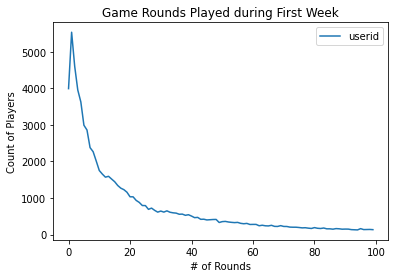

In [ ]:
# This command makes plots appear in the notebook
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = cc_data.groupby('sum_gamerounds').count().reset_index()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(n=100).plot('sum_gamerounds', 'userid')
ax.set_xlabel("# of Rounds")
ax.set_ylabel("Count of Players")
ax.set_title("Game Rounds Played during First Week");

In the plot above we can see that some players install the game but then never play it (0 game rounds). Let's find there are how many of them.

In [ ]:
cc_data[cc_data["sum_gamerounds"]== 0]["userid"].count()

3994

# Inferential Statistics

## Retention (1 & 7 days)


### Overall

In [ ]:
df_retention = cc_data[["retention_1","retention_7"]].mean()*100
print(f"1-day retention ratio: {round(df_retention[0],2)}% \
      \n7-days retention ratio: {round(df_retention[1],2)}%")

1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


### Retention by AB-group

In [ ]:
# Calculating 1-day and 7-days retention for each A/B group
df_retention_ab = cc_data.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


**OR**

In [ ]:
# Calculating 1-day retention for each AB-group
cc_data.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

💡 There was a **slight decrease in 1-day retention** when the gate was moved to level 40 (44.2%) compared to the control group when it was at level 30 (44.8%).

In [ ]:
# Calculating 7-days retention for each AB-group
cc_data.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

💡 Again, a **decrease in 7-day retention** when the gate was moved to level 40 (18.2%) compared to the control group when it was at level 30 (19.8%).

## Should we be confident in the difference?
It's a **small change**, but even **small changes in retention can have a large impact**. But while we are certain of the difference in the data, **how certain should we be that a gate at level 40 will be worse in the future**?

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use ***bootstrapping***: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

In [ ]:
import matplotlib.pyplot as plt

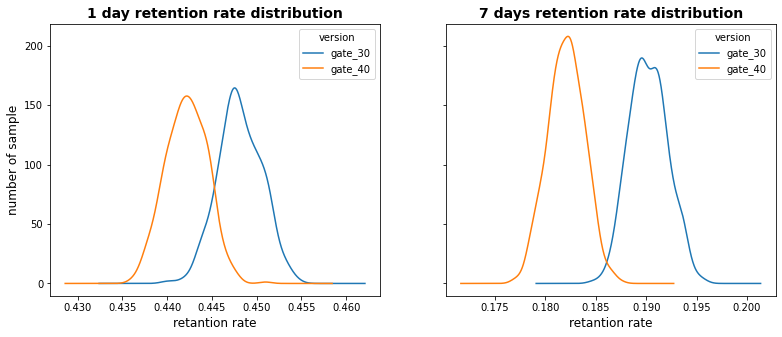

In [ ]:
# Creating an list with bootstrapped means for each A/B group
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = cc_data.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = cc_data.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

## Zooming on the Difference
These two distributions above represent the bootstrap uncertainty over what the underlying 1-day and 7-days retention could be for the two AB-groups. Just eyeballing this plot, we can see that **there seems to be some evidence of a difference**, albeit small. Let's zoom in on the difference in 1-day retention

In [ ]:
# checking first few rows of boot_1d 
boot_1d.head()

version,gate_30,gate_40
retention_1,0.450061,0.439593
retention_1,0.450011,0.440120
retention_1,0.449064,0.441918
retention_1,0.446599,0.442947
retention_1,0.447361,0.443272


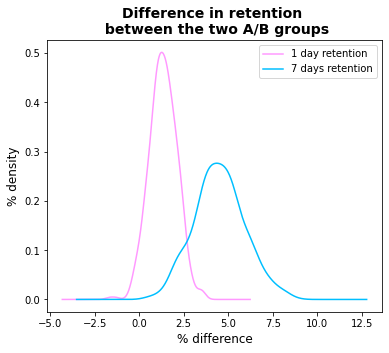

In [ ]:
# Adding a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

💡 From these chart, we can see that the **most likely % difference is around 1% - 2% for 1-day retention**. **For 7-days** retention the most likely % difference is** around 2% - 5%**. Moreover, the most of the distribution is above 0%, in favor of a gate at level 30. But what is the probability that the difference is above 0%? Let's calculate that as well.

## The Probability of a Difference

In [ ]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Calculating the probability that 7-days retention is greater when the gate is at level 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

# Pretty printing the probability
print(f"The probability that 1-day retention is greater when the gate is at level 30: {round(prob_1,2)*100}% \
      \nThe probability that 7-days retention is greater when the gate is at level 30: {(prob_7)*100}% ")

The probability that 1-day retention is greater when the gate is at level 30: 96.0%       
The probability that 7-days retention is greater when the gate is at level 30: 100.0% 


# The Conclusion
The bootstrap result tells us that there is strong evidence **99.8% probability** that 7-day retention is higher when the gate is at level 30 than when it is at level 40.

The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — **we should not move the gate from level 30 to level 40**. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics.